In [10]:
from glob import iglob
from itertools import chain
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
datasets = (
    pd
    .read_excel("Data/Run list.xlsx", sheet_name="Datasets")
    .set_index("Dataset")
)
datasets.head()

,First Run num,Last Run num,Wavelength (eV),Undulators,Opt ph offset (rad),Opt ph offset err (rad)
Dataset,,,,,,
alt1,186,203,15.9,5U(ω)+1U(2ω),NaN,NaN
alt2,252,314,14.3,5U(ω)+1U(2ω),NaN,NaN
alt3,333,365,14.3,5U(ω)+1U(2ω),NaN,NaN
alt4,453,460,14.3,5U(ω)+1U(2ω),NaN,NaN
bad,-1,-1,NaN,NaN,NaN,NaN


In [12]:
def _read(filename: str) -> dict:
    with open(filename, "r") as fp:
        d = json.load(fp)

    for r in d["Grouped by"]["Polar ang fr (deg)"]:
        shift = {
            p["Name"]: p
            for p in r["Model result"]["Params"]
        }["shift"]
        yield {
            "Dataset": d["Dataset"],
            "Polar ang fr (deg)": r["Value"],
            "Phase shift (rad)": shift["Value"],
            "Phase shift err (rad)": shift["Std err"],
        }


def _calib(df: pd.DataFrame) -> pd.Series:
    return pd.Series({
        "Phase shift (rad)": (df["Phase shift (rad)"] - df["Opt ph offset (rad)"]) % (2 * np.pi),
        "Phase shift err (rad)": (df["Phase shift err (rad)"] ** 2 + df["Opt ph offset err (rad)"] ** 2) ** 0.5,
        "Photon energy (eV)": df["Wavelength (eV)"],
    })

filenames = iglob("Data/Phase shifts - *.yaml")
it = chain.from_iterable((d for d in _read(fn)) for fn in filenames)
data = (
    pd
    .DataFrame([d for d in it])
    .set_index(["Dataset", "Polar ang fr (deg)"])
    .merge(datasets, left_index=True, right_index=True)
    .apply(_calib, axis=1)
)
data.head()

Phase shift (rad)  Phase shift err (rad)  \
Dataset Polar ang fr (deg)                                             
good1   0                            1.063717               0.112039   
        5                            1.443879               0.111267   
        10                           1.174429               0.082094   
        15                           1.372884               0.082494   
        20                           1.492901               0.094106   

                            Photon energy (eV)  
Dataset Polar ang fr (deg)                      
good1   0                                 15.9  
        5                                 15.9  
        10                                15.9  
        15                                15.9  
        20                                15.9

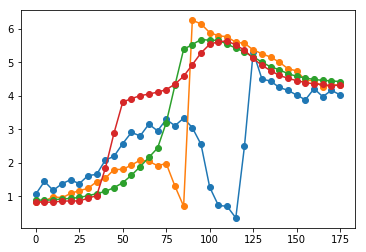

In [16]:
colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
]

for k, c in zip(["good1", "good2", "good3", "good4"], colors):
#     if k in {"good1"}:
#         continue
    sliced = data.loc[k, :]
    plt.plot(sliced.index, sliced["Phase shift (rad)"], "-o", color=c)
plt.show()